## Ex 5: Generalization of Steamboat to Slide-tags Data

- Data: [Russell, Andrew JC, et al. "Slide-tags enables single-nucleus barcoding for multimodal spatial genomics." Nature 625.7993 (2024): 101-109.](https://www.nature.com/articles/s41586-023-06837-4)
- Tasks: Apply Steamboat to this new dataset

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
import torch

import sys
sys.path.append("../")
import steamboat as sf

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
plt.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'
matplotlib.rcParams['font.family'] = 'arial'
matplotlib.rcParams["legend.handletextpad"] = 0.
matplotlib.rcParams["legend.labelspacing"] = .3
pltkw = dict(bbox_inches='tight', transparent=True)

device = 'cuda'

c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\spatialdata\_core\query\relational_query.py:530: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left = partial(_left_join_spatialelement_table)
c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\spatialdata\_core\query\relational_query.py:531: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left_exclusive = parti

## Load data

In [2]:
if False: # Set to True to re-process raw data
    data = pd.read_csv("G:/data/slidetags/HumanTonsil_expression.csv.gz", index_col=0)
    metadata = pd.read_csv("G:/data/slidetags/HumanTonsil_metadata.csv", index_col=0, skiprows=[1])
    spatial = pd.read_csv("G:/data/slidetags/HumanTonsil_spatial.csv", index_col=0, skiprows=[1])
    adata = sc.AnnData(data.T, obs=metadata.loc[data.columns])
    adata.obsm["spatial"] = spatial.loc[data.columns, ['X', 'Y']].to_numpy()

    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
    adata = adata[:, adata.var.highly_variable]
else:
    adata = sc.read_h5ad("../../../data/slidetags/HumanTonsil_2000.h5ad")

adata.obs['global'] = 0
adatas = sf.prep_adatas([adata], norm=False, log1p=False, n_neighs=8)
dataset = sf.make_dataset(adatas, sparse_graph=True, regional_obs=['global'])

  0%|          | 0/1 [00:00<?, ?it/s]

Using None to mask variables. Explicitly specify `mask_var=False` to use all genes.
Using ['global'] as regional annotations.


  0%|          | 0/1 [00:00<?, ?it/s]

## Train Steamboat model

In [3]:
sf.set_random_seed(0)
model = sf.Steamboat(adata.var_names.tolist(), n_heads=60, n_scales=3)
model = model.to(device)

if False:  # Set to True to re-train the model
    model.fit(dataset.to(device), entry_masking_rate=0.1, feature_masking_rate=0.1,
             max_epoch=10000, 
             loss_fun=torch.nn.MSELoss(reduction='sum'),
             opt=torch.optim.Adam, opt_args=dict(lr=0.1), stop_eps=2e-5, report_per=1000, stop_tol=250, device=device)

    torch.save(model.state_dict(), 'saved_models/tonsil.pth')
else:
    model.load_state_dict(torch.load('saved_models/tonsil.pth'))

## Clustering and evaluation

In [4]:
sf.tools.calc_obs(adatas, dataset, model, get_recon=True)
sf.tools.gather_obs(adata, adatas)

  0%|          | 0/1 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 5778 × 2000
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'cluster', 'global'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'hvg', 'neighbors', 'pca', 'umap', 'spatial_neighbors', 'global_k_0'
    obsm: 'X_pca', 'X_umap', 'spatial', 'X_recon', 'q', 'local_k', 'global_k_0', 'attn', 'ego_attn', 'local_attn', 'global_attn_0', 'global_attn'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances', 'local_attn_0', 'local_attn_1', 'local_attn_2', 'local_attn_3', 'local_attn_4', 'local_attn_5', 'local_attn_6', 'local_attn_7', 'local_attn_8', 'local_attn_9', 'local_attn_10', 'local_attn_11', 'local_attn_12', 'local_attn_13', 'local_attn_14', 'local_attn_15', 'local_attn_16', '

c:\Files\projects\Steamboat\examples\..\steamboat\tools.py:726: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  return sc.tl.leiden(adata, obsp=obsp, key_added=key_added, resolution=resolution, **leiden_kwargs)


NMI: 0.7434, ARI: 0.5968, n_clusters: 13


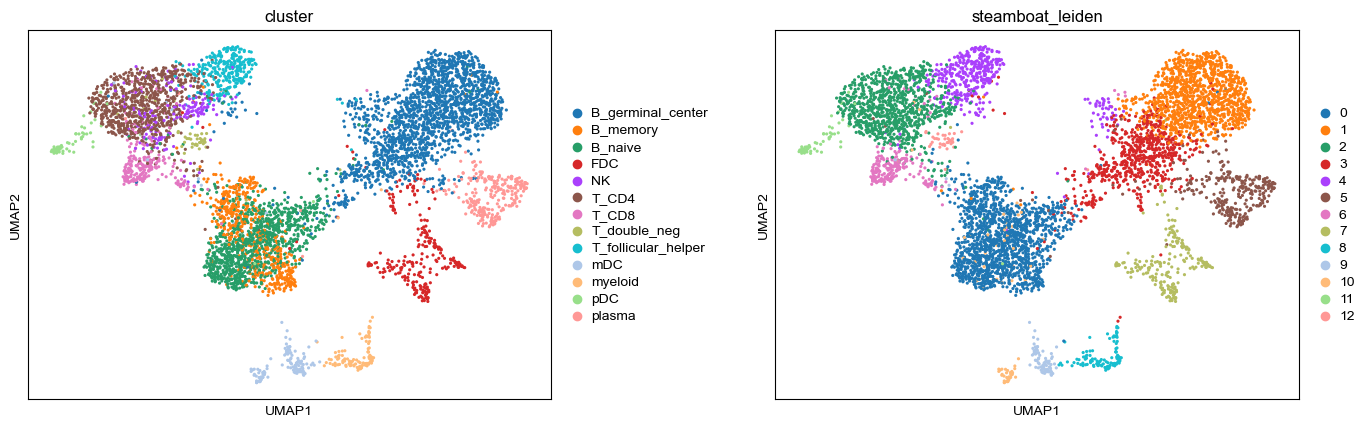

In [5]:
sf.tools.neighbors(adata)
sf.tools.leiden(adata, key_added='steamboat_leiden', resolution=.5)
sc.tl.umap(adata)

labels_true = adata.obs['cluster'].values
labels_pred = adata.obs['steamboat_leiden'].values
nmi = normalized_mutual_info_score(labels_true, labels_pred)
ari = adjusted_rand_score(labels_true, labels_pred)
n_clusters = len(np.unique(labels_pred))

print(f"NMI: {nmi:.4f}, ARI: {ari:.4f}, n_clusters: {n_clusters}")

# Visualization
sc.pl.umap(adata, color=['cluster', 'steamboat_leiden'], wspace=0.3)

In [6]:
# Use binary search to find resolution that gives correct number of clusters, then evaluate NMI and ARI

target_n_clusters = len(np.unique(labels_true))

adata.obsm['std_attn'] = adata.obsm['attn'] / adata.obsm['attn'].std(axis=0, keepdims=True)
sc.pp.neighbors(adata, use_rep='std_attn', key_added='sf', metric='cosine')

low, high = 0.1, 2.0
for _ in range(10):
    mid = (low + high) / 2
    # Get predicted labels from std_attn using Leiden clustering
    sc.tl.leiden(adata, resolution=mid, key_added='std_attn_leiden', neighbors_key='sf')
    labels_pred = adata.obs['std_attn_leiden'].values
    n_clusters = len(np.unique(labels_pred))
    if n_clusters < target_n_clusters:
        low = mid
    elif n_clusters > target_n_clusters:
        high = mid
    else:
        break
else:
    sc.tl.leiden(adata, resolution=mid, key_added='temp_leiden')

labels_pred = adata.obs['std_attn_leiden'].values
nmi = normalized_mutual_info_score(labels_true, labels_pred)
ari = adjusted_rand_score(labels_true, labels_pred)


print(f"resolution: {mid:.4f}, NMI: {nmi:.4f}, ARI: {ari:.4f}, n_clusters: {n_clusters}")

resolution: 0.5750, NMI: 0.7526, ARI: 0.6667, n_clusters: 13


## Domain segmentation

c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\squidpy\pl\_spatial_utils.py:982: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\squidpy\pl\_spatial_utils.py:982: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


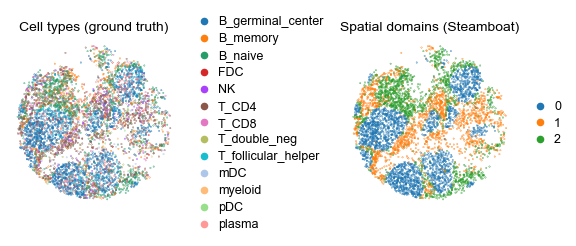

In [7]:
sf.tools.segment(adata, resolution=0.5, key_added="steamboat_spatial_domain", n_prop=2)

fig = plt.figure(figsize=(6.5, 2.5))
gs = GridSpec(1, 2, width_ratios=[1, 1.], hspace=.5, wspace=1., figure=fig)
axes = [fig.add_subplot(gs[:, 0])] + [fig.add_subplot(gs[i, 1]) for i in range(1)]

##########################
ax = axes[0]
sq.pl.spatial_scatter(adata, color="cluster", size=.1, shape=None, ax=ax, legend_loc='right margin', frameon=False)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Cell types (ground truth)", size=10)
# ax.legend(handletextpad=0.05)

legend = ax.get_legend()
if legend:
    legend.set_title(legend.get_title().get_text(), prop={'size': 8})  # Adjust legend title size
    for text in legend.get_texts():
        text.set_fontsize(9)  # Adjust legend text size
    for handle in legend.legend_handles:
        handle.set_sizes([20])  # Adjust dot size in legend

# sq.pl.spatial_scatter(adata, color="steamboat_spatial_domain", size=.1, shape=None, ax=axes[1], legend_loc='right margin', frameon=False)
# axes[1].set_xlabel("")
# axes[1].set_ylabel("")
# axes[1].set_title("Spatial domains\nlow resolution\n(Steamboat)", size=10)
#################
ax = axes[1]
sq.pl.spatial_scatter(adata, color="steamboat_spatial_domain", size=.1, shape=None, ax=ax, legend_loc='right margin', frameon=False)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Spatial domains (Steamboat)", size=10)

legend = ax.get_legend()
if legend:
    legend.set_title(legend.get_title().get_text(), prop={'size': 8})  # Adjust legend title size
    for text in legend.get_texts():
        text.set_fontsize(9)  # Adjust legend text size
    for handle in legend.legend_handles:
        handle.set_sizes([20])  # Adjust dot size in legend

## Infer cell-cell interactions

<Axes: >

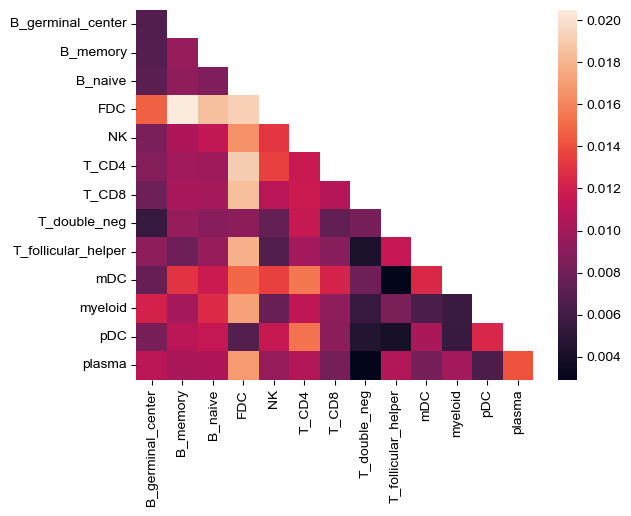

In [8]:
cci_matrix = sf.tools.calc_interaction(adatas, model, 'biosample_id', 'cluster')['tonsil1']
plot_matrix = cci_matrix.copy()
for i in range(len(plot_matrix)):
    for j in range(i + 1, len(plot_matrix)):
        plot_matrix.iloc[i, j] = float('nan')
sns.heatmap(plot_matrix)

## List known L-R pairs

  0%|          | 0/60 [00:00<?, ?it/s]

15


Text(28.972222222222214, 0.5, 'Ligand-Receptor Pairs')

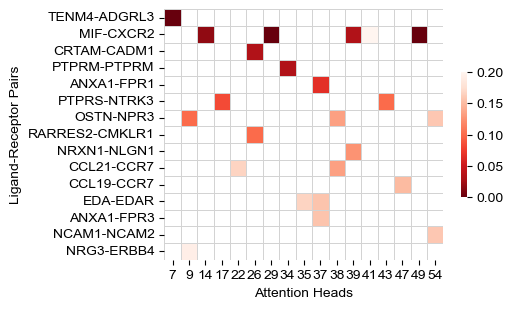

In [9]:
lrp_dfs = sf.tools.score_lrs(adata, model, None, gene_names='index')

good_lrs = {}
for i in range(model.spatial_gather.n_heads):
    temp = lrp_dfs[i][lrp_dfs[i]['adj_p'] <= 0.2]
    for lr, p in zip(temp['lr'], temp['adj_p']):
        if lr not in good_lrs:
            good_lrs[lr] = p
        else:
            good_lrs[lr] = min(good_lrs[lr], p)

sorted_lrs = sorted(good_lrs.items(), key=lambda x: x[1])
sorted_lrs = [x[0] for x in sorted_lrs]
print(len(sorted_lrs))
inv_sorted_lrs = {x: idx for idx, x in enumerate(sorted_lrs)}

heatmap_df = pd.DataFrame(float('nan'), index=sorted_lrs, columns=list(range(model.spatial_gather.n_heads)))
for i in range(model.spatial_gather.n_heads):
    temp = lrp_dfs[i][lrp_dfs[i]['adj_p'] <= 0.2]
    for lr, p in zip(temp['lr'], temp['adj_p']):
        if lr in heatmap_df.index:
            heatmap_df.loc[lr, i] = p

heatmap_df = heatmap_df.loc[:, heatmap_df.isna().sum(axis=0) < heatmap_df.shape[0]]

fig, ax = plt.subplots(figsize=(4.5, 3.25))
sns.heatmap(heatmap_df, cmap='Reds_r', ax=ax, cbar_kws={'shrink': 0.5}, linewidths=.5, linecolor='lightgray')
ax.set_xticks(np.arange(len(heatmap_df.columns)) + 0.5)
ax.set_xticklabels(heatmap_df.columns.tolist(), rotation=0)
ax.set_xlabel('Attention Heads')
ax.set_ylabel('Ligand-Receptor Pairs')